## Dacon 농업 환경 변화에 따른 작물 병해 진단 AI 경진대회


저는 "convnext_xlarge_384_in22ft1k+Vanilla LSTM" 구조의 ConvNext과 LSTM 모델을 다음 구성으로 사용했습니다.

* ImageNet-22K에 pretrain된 가중치 로드
* (384, 384)의 이미지 크기
* Train Augmentation : Resize, ShiftScaleRotate, HorizontalFlip, VerticalFlip, RandomRotate90, CLAHE, Sharpen, RandomBrightnessContrast, RandomResizedCrop, Normalize
* Valid Augmentation : Resize, HorizontalFlip, VerticalFlip, Normalize
* Test Augmentation : Resize, Normalize
* 320 길이의 환경 변수 데이터(온도, 습도, 이슬점의 평균, 최고, 최저)
* Embedding Vector의 크기는 LSTM : 2048, Image Model : 1024
* gamma=2.0인 Focal Loss
* 30 epoch까지 2e-7까지 learning rate가 떨어지는 CosineAnnealingLR 스케줄러를 사용한 Adamw 옵티마이저(lr=1e-4,weigt decay=1e-3)
* 30 epoch의 5-fold-CV(validation F1-macro Score가 가장 높은 모델을 선택)
* AMP를 이용한 학습
* 단일 모델의 5개 fold의 예측 확률을 누적 평균한 예측 결과를 최종 결과로 제출했습니다.

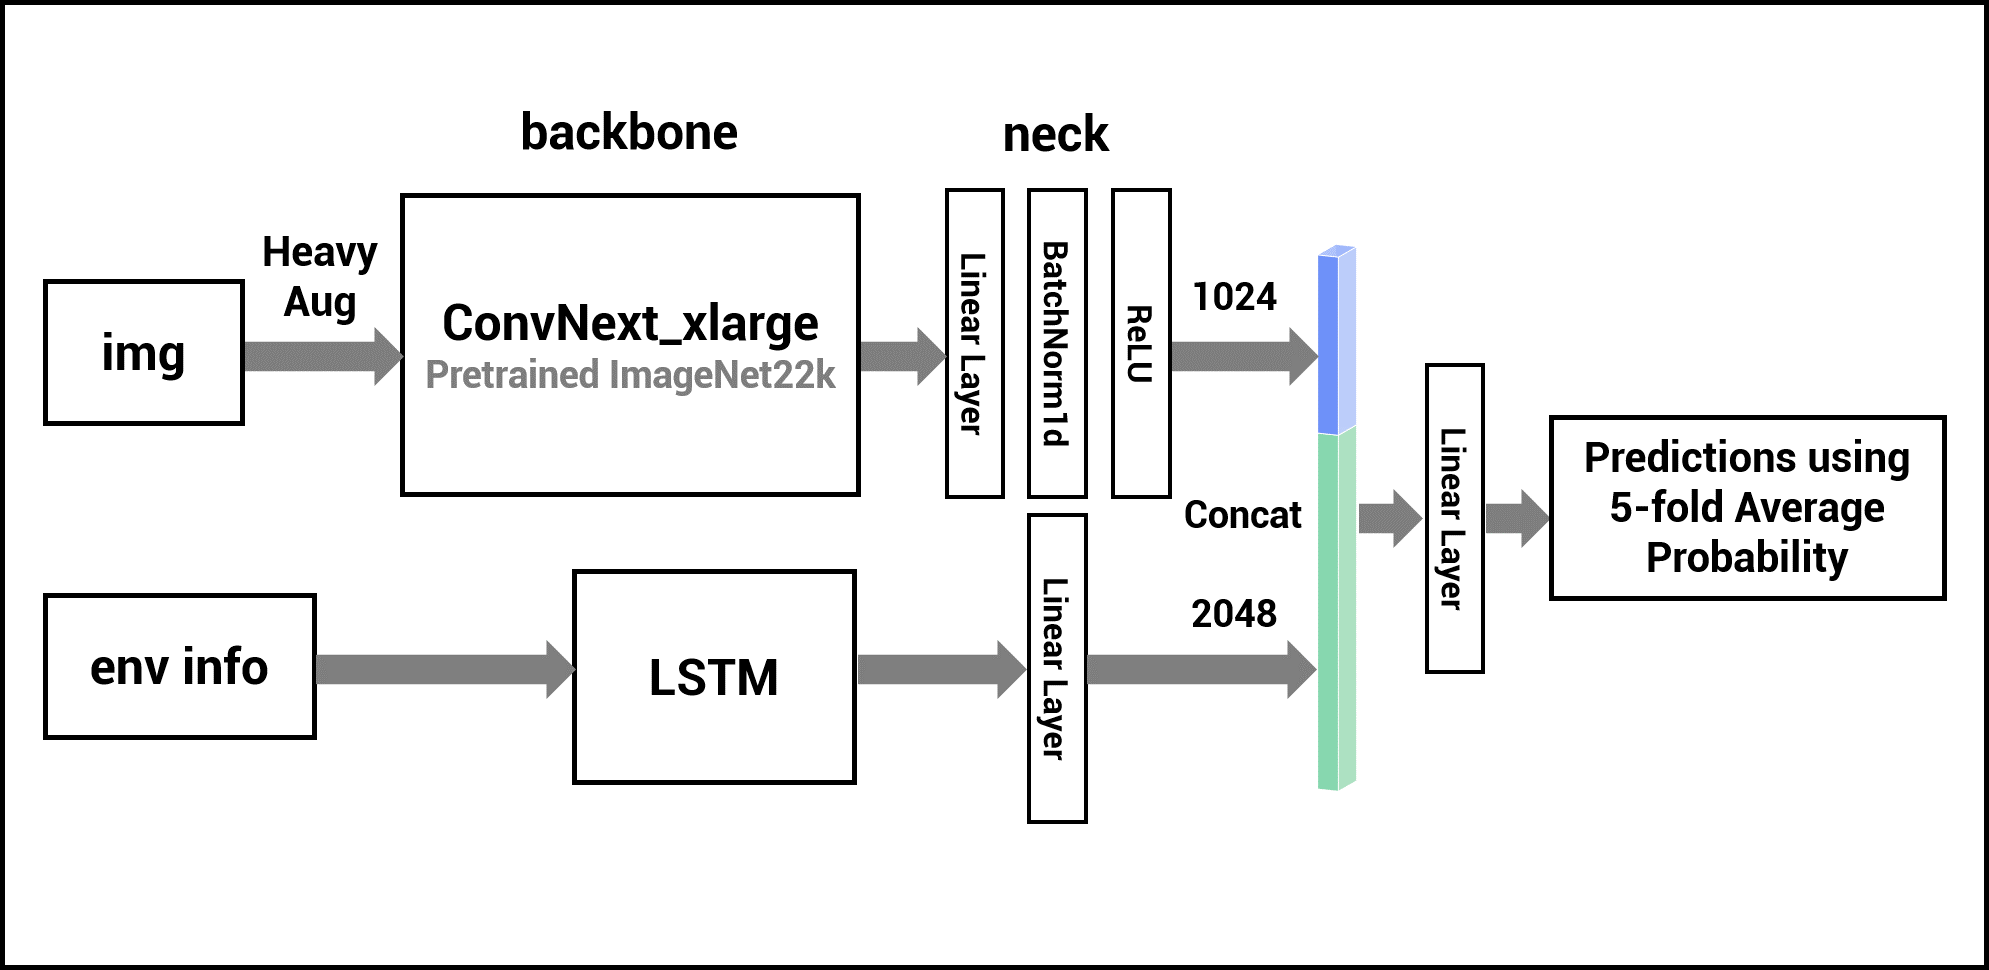

## Development Environment
Ubuntu 18.04.5 LTS



In [1]:
# -*- encoding: utf-8 -*-

import os
import numpy as np
import pandas as pd

from tqdm import tqdm
from glob import glob
from datetime import datetime
import time

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import argparse

from dataset import PlantDACON

import timm
import torch_optimizer as optim

import wandb
import logging

from torch.optim.lr_scheduler import _LRScheduler

from torch.cuda.amp import autocast
from torch.cuda.amp import GradScaler

In [2]:
import torch
from torch import nn
from torchvision import models
from collections import OrderedDict
import timm
import torch.nn.functional as F

In [3]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm

import json
import torch
from torch.utils.data import Dataset
import albumentations as albu
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
from albumentations.pytorch import ToTensorV2

class PlantDACON(Dataset):
    def __init__(self,
                 image_size,
                 files,
                 csv_files=None,
                 avail_features=None,
                 label_description=None,
                 aug_ver=0,
                 tta_transform=None,
                 mode='train'):
        self.mode = mode
        self.image_size = image_size
        self.files = files
        self.aug_ver = aug_ver
        self.avail_features = avail_features
        self.csv_files = csv_files
        self.csv_feature_check = [0] * len(self.files)
        self.csv_features = [None] * len(self.files)
        self.max_len = 320
        self.label_description = label_description
        self.label_encoder = {key: idx for idx, key in enumerate(self.label_description)}
        self.base_transform_list = [
            albu.Resize(self.image_size, self.image_size),
            albu.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1,
                                  rotate_limit=30, interpolation=1, border_mode=0,
                                  value=0, p=0.5),
            albu.HorizontalFlip(p=0.5),
            albu.VerticalFlip(p=0.5)
        ]


        self.tta_transform = tta_transform
        self.transform_normalize = [
            albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
            ToTensorV2()
        ]
        if self.mode == 'train':
            # Only-flip
            if self.aug_ver == 1:
                self.transform = albu.Compose([albu.Resize(self.image_size, self.image_size),
                                               albu.HorizontalFlip(p=0.5),
                                               albu.VerticalFlip(p=0.5),
                                               albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                                               ToTensorV2(),
                                               ])
            # Base Augmentation
            elif self.aug_ver == 2:
                self.transform = albu.Compose(
                    self.base_transform_list
                    + self.transform_normalize)

            elif self.aug_ver == 29:
                self.transform = albu.Compose(
                    self.base_transform_list +
                    [
                        albu.RandomRotate90(p=1.0),
                        albu.CLAHE(clip_limit=2, p=0.25),
                        albu.Sharpen(p=0.25),
                        albu.RandomBrightnessContrast(brightness_limit=(-0.1, 0.1),
                                                      contrast_limit=(-0.1, 0.1), p=0.25),
                        albu.RandomResizedCrop(height=self.image_size, width=self.image_size,
                                               scale=(0.5, 1.0), ratio=(0.75, 1.3333333333333333),
                                               interpolation=1, p=1.0),
                    ]
                    + self.transform_normalize)
            else :
                self.transform = albu.Compose([albu.Resize(self.image_size, self.image_size),
                                               albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                                               ToTensorV2(),
                                               ])
        elif self.mode == 'valid':
            self.transform = albu.Compose([
                albu.Resize(self.image_size, self.image_size),
                albu.HorizontalFlip(p=0.5),
                albu.VerticalFlip(p=0.5),
                albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                ToTensorV2(),
            ])
        elif self.mode == 'test':
            if self.tta_transform:
                self.transform = albu.Compose(
                    [albu.Resize(self.image_size, self.image_size)]+
                    [
                        self.tta_transform
                    ]
                    + self.transform_normalize)
            else:
                self.transform = albu.Compose([
                    albu.Resize(self.image_size, self.image_size),
                    albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                    ToTensorV2(),
                ])
        else:
            self.transform = albu.Compose([
                albu.Resize(self.image_size, self.image_size),
                albu.Normalize(mean=IMAGENET_DEFAULT_MEAN, std=IMAGENET_DEFAULT_STD),
                ToTensorV2(),
            ])


        if avail_features:
            self.csv_feature_dict = self.make_csv_feature_dict()
#             self.csv_feature_dict = {'내부 온도 1 평균': [3.4, 47.3],
#                                      '내부 온도 1 최고': [3.4, 47.6],
#                                      '내부 온도 1 최저': [3.3, 47.0],
#                                      '내부 습도 1 평균': [23.7, 100.0],
#                                      '내부 습도 1 최고': [25.9, 100.0],
#                                      '내부 습도 1 최저': [0.0, 100.0],
#                                      '내부 이슬점 평균': [0.1, 34.5],
#                                      '내부 이슬점 최고': [0.2, 34.7],
#                                      '내부 이슬점 최저': [0.0, 34.4]}
    def make_csv_feature_dict(self):
        # 분석에 사용할 feature 선택
        temp_csv = pd.read_csv(self.csv_files[0])[self.avail_features]
        max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

        # feature 별 최대값, 최솟값 계산
        for csv in tqdm(self.csv_files[1:]):
            temp_csv = pd.read_csv(csv)[self.avail_features]
            temp_csv = temp_csv.replace('-', np.nan).dropna()
            if len(temp_csv) == 0:
                continue
            temp_csv = temp_csv.astype(float)
            temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
            max_arr = np.max([max_arr, temp_max], axis=0)
            min_arr = np.min([min_arr, temp_min], axis=0)

        # feature 별 최대값, 최솟값 dictionary 생성
        csv_feature_dict = {self.avail_features[i]: [min_arr[i], max_arr[i]] for i in range(len(self.avail_features))}
        return csv_feature_dict

    def get_csv_feature_dict(self):
        return self.csv_feature_dict

    def __len__(self):
        return len(self.files)

    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]

        json_path = f'{file}/{file_name}.json'
        image_path = f'{file}/{file_name}.jpg'
        if self.avail_features:
            if self.csv_feature_check[i] == 0:
                csv_path = f'{file}/{file_name}.csv'
                df = pd.read_csv(csv_path)[self.csv_feature_dict.keys()]
                df = df.replace('-', 0)
                # MinMax scaling
                for col in df.columns:
                    df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                    df[col] = df[col] / (self.csv_feature_dict[col][1] - self.csv_feature_dict[col][0])
                # zero padding
                pad = np.zeros((self.max_len, len(df.columns)))
                length = min(self.max_len, len(df))
                pad[-length:] = df.to_numpy()[-length:]
                # transpose to sequential data
                csv_feature = pad.T
                self.csv_features[i] = csv_feature
                self.csv_feature_check[i] = 1
            else:
                csv_feature = self.csv_features[i]
        else:
            pass

        img = cv2.imread(image_path)
        img = self.transform(image=img)

        if self.avail_features:
            if self.mode in ['train', 'valid']:
                with open(json_path, 'r') as f:
                    json_file = json.load(f)

                crop = json_file['annotations']['crop']
                disease = json_file['annotations']['disease']
                risk = json_file['annotations']['risk']
                label = f'{crop}_{disease}_{risk}'
                return {
                    'img': img,
                    'csv_feature': torch.tensor(csv_feature, dtype=torch.float32),
                    'label': torch.tensor(self.label_encoder[label], dtype=torch.long)
                }

            else:
                return {
                    'img': img,
                    'csv_feature': torch.tensor(csv_feature, dtype=torch.float32)
                }
        else:
            if self.mode in ['train', 'valid']:
                with open(json_path, 'r') as f:
                    json_file = json.load(f)

                crop = json_file['annotations']['crop']
                disease = json_file['annotations']['disease']
                risk = json_file['annotations']['risk']
                label = f'{crop}_{disease}_{risk}'

                return {
                    'img': img,
                    'label': torch.tensor(self.label_encoder[label], dtype=torch.long)
                }

            else:
                return {
                    'img': img,
                }

In [4]:
class ImageModel(nn.Module):
    def __init__(self, model_name, class_n, drop_path_rate, mode='train'):
        super().__init__()
        self.model_name = model_name.lower()
        self.class_n = class_n
        self.drop_path_rate = drop_path_rate
        self.mode = mode
        # 모델
        if self.model_name == 'convnext_large_384_in22ft1k':
            if self.mode == 'train' :
                self.encoder = timm.models.convnext_large_384_in22ft1k(pretrained=True, drop_path_rate=self.drop_path_rate)
            else:
                self.encoder = timm.models.convnext_large_384_in22ft1k(pretrained=True)
        elif self.model_name == 'convnext_base_384_in22ft1k':
            if self.mode == 'train' :
                self.encoder = timm.models.convnext_base_384_in22ft1k(pretrained=True, drop_path_rate=self.drop_path_rate)
            else:
                self.encoder = timm.models.convnext_base_384_in22ft1k(pretrained=True)
        else:
            if self.drop_path_rate != 0 :
                if self.mode == 'train' :
                    self.encoder = timm.create_model(self.model_name, pretrained=True, drop_path_rate=self.drop_path_rate)
                else:
                    self.encoder = timm.create_model(model_name, pretrained=True)
            else:
                self.encoder = timm.create_model(model_name, pretrained=True)

        names = []
        modules = []
        for name, module in self.encoder.named_modules():
            names.append(name)
            modules.append(module)

        self.fc_in_features = self.encoder.num_features
        print(f'The layer was modified...')

        fc_name = names[-1].split('.')

        if len(fc_name)==1:
            print(f'{getattr(self.encoder,fc_name[0])} -> Linear(in_features={self.fc_in_features}, out_features={class_n}, bias=True)')
            setattr(self.encoder, fc_name[0], nn.Linear(self.fc_in_features, class_n))
        elif len(fc_name)==2:
            print(f'{getattr(getattr(self.encoder,fc_name[0]),fc_name[1])} -> Linear(in_features={self.fc_in_features}, out_features={class_n}, bias=True)')
            setattr(getattr(self.encoder,fc_name[0]), fc_name[1], nn.Linear(self.fc_in_features, class_n))

    def forward(self, x):
        x = self.encoder(x)

        return x

class LSTM_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, cnn_features_len, class_n, rate):
        super(LSTM_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        # self.lstm_fc = nn.Linear(embedding_dim * 2 if bidirectional else embedding_dim, 2048)
        self.lstm_fc = nn.Linear(num_features*embedding_dim, 2048)
        self.final_layer = nn.Linear(cnn_features_len + 2048, class_n)
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        self.lstm.flatten_parameters()
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.lstm_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output


class ArcMarginProduct(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.weight = nn.Parameter(torch.FloatTensor(out_features, in_features))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.weight)

    def forward(self, features):
        cosine = F.linear(F.normalize(features), F.normalize(self.weight))
        return cosine


class ArcfaceImageModel(nn.Module):
    def __init__(self, model_name, class_n, drop_path_rate, embedding_dim=1024, mode='train', encode=False):
        super().__init__()
        self.model_name = '_'.join(model_name.lower().split('_')[1:])
        self.class_n = class_n
        self.drop_path_rate = drop_path_rate
        self.embedding_dim = embedding_dim
        self.mode = mode
        self.encode = encode
        # 모델
        if self.model_name == 'convnext_xlarge_384_in22ft1k':
            if self.mode == 'train' :
                self.encoder = timm.models.convnext_xlarge_384_in22ft1k(pretrained=True, drop_path_rate=self.drop_path_rate)
            else:
                self.encoder = timm.models.convnext_xlarge_384_in22ft1k(pretrained=True)
        elif self.model_name == 'convnext_large_384_in22ft1k':
            if self.mode == 'train' :
                self.encoder = timm.models.convnext_large_384_in22ft1k(pretrained=True, drop_path_rate=self.drop_path_rate)
            else:
                self.encoder = timm.models.convnext_large_384_in22ft1k(pretrained=True)
        elif self.model_name == 'convnext_base_384_in22ft1k':
            if self.mode == 'train' :
                self.encoder = timm.models.convnext_base_384_in22ft1k(pretrained=True, drop_path_rate=self.drop_path_rate)
            else:
                self.encoder = timm.models.convnext_base_384_in22ft1k(pretrained=True)
        else:
            if self.drop_path_rate != 0 :
                if self.mode == 'train' :
                    self.encoder = timm.create_model(self.model_name, pretrained=True, drop_path_rate=self.drop_path_rate)
                else:
                    self.encoder = timm.create_model(self.model_name, pretrained=True)
            else:
                self.encoder = timm.create_model(self.model_name, pretrained=True)

        names = []
        modules = []
        for name, module in self.encoder.named_modules():
            names.append(name)
            modules.append(module)

        self.fc_in_features = self.encoder.num_features
        print(f'The layer was modified...')

        fc_name = names[-1].split('.')

        if len(fc_name)==1:
            print(f'{getattr(self.encoder,fc_name[0])} -> Linear(in_features={self.fc_in_features}, out_features={1000}, bias=True)')
            setattr(self.encoder, fc_name[0], nn.Linear(self.fc_in_features, 1000))
        elif len(fc_name)==2:
            print(f'{getattr(getattr(self.encoder,fc_name[0]),fc_name[1])} -> Linear(in_features={self.fc_in_features}, out_features={1000}, bias=True)')
            setattr(getattr(self.encoder,fc_name[0]), fc_name[1], nn.Linear(self.fc_in_features, 1000))

        self.neck = nn.Sequential(
            nn.Linear(1000, self.embedding_dim, bias=True),
            nn.BatchNorm1d(self.embedding_dim),
            torch.nn.ReLU()
        )

        self.arc_margin_product = ArcMarginProduct(self.embedding_dim, self.class_n)


    def forward(self, x):
        x = self.encoder(x)
        x = self.neck(x)
        logits = self.arc_margin_product(x)
        if self.encode :
            return x
        else:
            return logits

class ImageModel2LSTMModel(nn.Module):
    def __init__(
            self,
            model_name,
            pretrained_model_path,
            max_len,
            img_embedding_dim,
            env_embedding_dim,
            num_features,
            class_n,
            dropout_rate=0.1,
            mode='train'
    ):
        super(ImageModel2LSTMModel, self).__init__()
        self.model_name = model_name
        self.pretrained_model_path = pretrained_model_path
        self.mode = mode
        self.class_n = class_n
        self.dropout_rate = dropout_rate
        self.max_len = max_len
        self.img_embedding_dim = img_embedding_dim
        self.env_embedding_dim = env_embedding_dim
        self.num_features = num_features

        # When using new data (existing data + aihub pepper white powder data), 25 when it's not 28
        if self.pretrained_model_path :
            self.encoder = ArcfaceImageModel(model_name, 25, drop_path_rate=0, embedding_dim=self.img_embedding_dim,
                                             mode='test', encode=True)
            self.encoder.load_state_dict(torch.load(self.pretrained_model_path)['model_state_dict'])
            self.encoder.requires_grad = False
        else:
            self.encoder = ArcfaceImageModel(model_name, 25, drop_path_rate=0.2, embedding_dim=self.img_embedding_dim,
                                             mode='train', encode=True)

        self.rnn = LSTM_Decoder(self.max_len, self.env_embedding_dim, self.num_features, cnn_features_len=self.img_embedding_dim, class_n=self.class_n, rate=self.dropout_rate)

    def forward(self, img, seq):
        cnn_output = self.encoder(img)
        output = self.rnn(cnn_output, seq)
        return output

In [5]:
import torch
from torch import nn
import torch.nn.functional as F
import math

class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2, factor=0.1, reduction='mean'):
        super(FocalLoss, self).__init__(weight, reduction=reduction)
        self.gamma = gamma
        self.weight = weight  # weight parameter will act as the alpha parameter to balance class weights
        self.factor = factor

    def forward(self, input, target):
        # num_classes = input.shape[-1]
        # target = smooth(target.float(), num_classes, self.factor)
        ce_loss = F.cross_entropy(input, target, reduction=self.reduction, weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

"""
https://github.com/dongkyuk/DOLG-pytorch/blob/main/model/arcface.py
"""
class ArcFaceLoss(nn.Module):
    def __init__(self, scale_factor=45.0, margin=0.10, criterion=None, weight=None):
        super(ArcFaceLoss, self).__init__()

        if criterion:
            self.criterion = criterion
        else:
            if weight:
                self.criterion = nn.CrossEntropyLoss(weight=weight)
            else:
                self.criterion = nn.CrossEntropyLoss()
        self.margin = margin
        self.scale_factor = scale_factor


        self.cos_m = math.cos(margin)
        self.sin_m = math.sin(margin)
        self.th = math.cos(math.pi - margin)
        self.mm = math.sin(math.pi - margin) * margin

    def forward(self, logits, label):
        # input is not l2 normalized
        logits = logits.float()
        cosine = logits
        sine = torch.sqrt(1.0 - torch.pow(cosine, 2))

        phi = cosine * self.cos_m - sine * self.sin_m
        phi = phi.type(cosine.type())
        phi = torch.where(cosine > self.th, phi, cosine - self.mm)

        one_hot = torch.zeros(cosine.size(), device=logits.device)
        one_hot.scatter_(1, label.view(-1, 1).long(), 1)

        logit = (one_hot * phi) + ((1.0 - one_hot) * cosine)
        logit *= self.scale_factor

        loss = self.criterion(logit, label)

        return loss

In [6]:
def rand_bbox(W, H, lam):
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    cx = np.random.randint(cut_w // 2, W - cut_w // 2)
    cy = np.random.randint(cut_h // 2, H - cut_h // 2)

    bbx1 = cx - cut_w // 2
    bby1 = cy - cut_h // 2
    bbx2 = cx + cut_w // 2
    bby2 = cy + cut_h // 2

    return bbx1, bby1, bbx2, bby2

def cutmix(x, y, alpha=1.0):
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = x.size()[0]
    index = torch.randperm(batch_size).cuda()

    bbx1, bby1, bbx2, bby2 = rand_bbox(x.size()[2], x.size()[3], lam)
    x[:, :, bbx1:bbx2, bby1:bby2] = x[index, :, bbx1:bbx2, bby1:bby2]
    y_a, y_b = y, y[index]
    return x, y_a, y_b, lam


class WarmUpLR(_LRScheduler):
    """warmup_training learning rate scheduler
    Args:
        optimizer: optimzier(e.g. SGD)
        total_iters: totoal_iters of warmup phase
    """

    def __init__(self, optimizer, total_iters, last_epoch=-1):
        self.total_iters = total_iters
        super().__init__(optimizer, last_epoch)

    def get_lr(self):
        """we will use the first m batches, and set the learning
        rate to base_lr * m / total_iters
        """
        return [base_lr * self.last_epoch / (self.total_iters + 1e-8) for base_lr in self.base_lrs]

In [7]:
def init_logger(save_dir, comment=None):
    c_date, c_time = datetime.now().strftime("%Y%m%d/%H%M%S").split('/')
    if comment is not None:
        if os.path.exists(os.path.join(save_dir, c_date, comment)):
            comment += f'_{c_time}'
    else:
        comment = c_time
    log_dir = os.path.join(save_dir, c_date, comment)
    log_txt = os.path.join(log_dir, 'log.txt')

    os.makedirs(f'{log_dir}/ckpts')
    os.makedirs(f'{log_dir}/submissions')
    os.makedirs(f'{log_dir}/comparisons')

    global logger
    logger = logging.getLogger(c_time)

    logger.setLevel(logging.INFO)
    logger = logging.getLogger(c_time)

    fmt = logging.Formatter("[%(asctime)s] %(message)s", datefmt='%Y-%m-%d %H:%M:%S')
    h_file = logging.FileHandler(filename=log_txt, mode='a')
    h_file.setFormatter(fmt)
    h_file.setLevel(logging.INFO)
    logger.addHandler(h_file)
    logger.info(f'Log directory ... {log_txt}')
    return log_dir

def accuracy_function(real, pred):
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    acc = (pred == real).sum()/real.shape[0]
    score = f1_score(real, pred, average='macro')
    return acc, score

In [8]:
def train(model, train_loader, criterion, optimizer, warmup_scheduler, scheduler, scaler, epoch, wandb, args):
    model.train()
    total_train_loss = 0
    total_train_acc = 0
    total_train_score = 0
    batch_iter = tqdm(enumerate(train_loader), 'Training', total=len(train_loader), ncols=150)

    # breakpoint()
    lam = None
    label_a, label_b = None, None
    for batch_idx, batch_item in batch_iter:
        optimizer.zero_grad()
        img = batch_item['img']['image'].cuda()
        label = batch_item['label'].cuda()

        if epoch <= args.warm_epoch:
            warmup_scheduler.step()

        if args.cutmix:
            r = np.random.rand(1)
            if r < args.cutmix_prob:
                img, label_a, label_b, lam = cutmix(img, label)

            if args.amp:
                with autocast():
                    if args.environment_feature:
                        csv_feature = batch_item['csv_feature'].cuda()
                        output = model(img, csv_feature)
                    else:
                        output = model(img)
            else:
                if args.environment_feature:
                    csv_feature = batch_item['csv_feature'].cuda()
                    output = model(img, csv_feature)
                else:
                    output = model(img)
            if r < args.cutmix_prob:
                train_loss = lam * criterion(output, label_a) + (1 - lam) * criterion(output, label_b)
            else:
                train_loss = criterion(output, label)
        else:
            if args.amp:
                with autocast():
                    if args.environment_feature:
                        csv_feature = batch_item['csv_feature'].cuda()
                        output = model(img, csv_feature)
                    else:
                        output = model(img)
            else:
                if args.environment_feature:
                    csv_feature = batch_item['csv_feature'].cuda()
                    output = model(img, csv_feature)
                else:
                    output = model(img)

            train_loss = criterion(output, label)

        if args.amp:
            scaler.scale(train_loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            train_loss.backward()
            optimizer.step()

        if args.scheduler == 'cycle':
            if epoch > args.warm_epoch:
                scheduler.step()

        train_acc, train_score = accuracy_function(label, output)
        total_train_loss += train_loss
        total_train_acc += train_acc
        total_train_score += train_score
        log = f'[EPOCH {epoch}] Train Loss : {train_loss.item():.4f}({total_train_loss / (batch_idx + 1):.4f}), '
        log += f'Train Acc : {train_acc.item():.4f}({total_train_acc / (batch_idx + 1):.4f}), '
        log += f'Train F1 : {train_score.item():.4f}({total_train_score / (batch_idx + 1):.4f})'
        if batch_idx+1 == len(batch_iter):
            log = f'[EPOCH {epoch}] Train Loss : {total_train_loss / (batch_idx + 1):.4f}, '
            log += f'Train Acc : {total_train_acc / (batch_idx + 1):.4f}, '
            log += f'Train F1 : {total_train_score / (batch_idx + 1):.4f}, '
            log += f"LR : {optimizer.param_groups[0]['lr']:.2e}"


        batch_iter.set_description(log)
        batch_iter.update()



    _lr = optimizer.param_groups[0]['lr']
    train_mean_loss = total_train_loss / len(batch_iter)
    train_mean_acc = total_train_acc / len(batch_iter)
    train_mean_f1 = total_train_score / len(batch_iter)

    logger.info(log)
    batch_iter.close()

    if args.wandb:
        wandb.log({'train_mean_loss': train_mean_loss, 'lr': _lr, 'train_mean_acc': train_mean_acc, 'train_mean_f1': train_mean_f1}, step=epoch)


@torch.no_grad()
def valid(model, val_loader, criterion, epoch, wandb, args):
    model.eval()
    total_val_loss = 0
    total_val_acc = 0
    total_val_score = 0

    batch_iter = tqdm(enumerate(val_loader), 'Validating', total=len(val_loader), ncols=150)

    for batch_idx, batch_item in batch_iter:
        img = batch_item['img']['image'].cuda()
        label = batch_item['label'].cuda()

        if args.environment_feature:
            csv_feature = batch_item['csv_feature'].cuda()
            with torch.no_grad():
                output = model(img, csv_feature)
        else:
            with torch.no_grad():
                output = model(img)

        val_loss = criterion(output, label)
        val_acc, val_score = accuracy_function(label, output)
        total_val_loss += val_loss
        total_val_acc += val_acc
        total_val_score += val_score

        log = f'[EPOCH {epoch}] Valid Loss : {val_loss.item():.4f}({total_val_loss / (batch_idx + 1):.4f}), '
        log += f'Valid Acc : {val_acc.item():.4f}({total_val_acc / (batch_idx + 1):.4f}), '
        log += f'Valid F1 : {val_score.item():.4f}({total_val_score / (batch_idx + 1):.4f})'
        if batch_idx+1 == len(batch_iter):
            log = f'[EPOCH {epoch}] Valid Loss : {total_val_loss / (batch_idx + 1):.4f}, '
            log += f'Valid Acc : {total_val_acc / (batch_idx + 1):.4f}, '
            log += f'Valid F1 : {total_val_score / (batch_idx + 1):.4f}'
        batch_iter.set_description(log)
        batch_iter.update()

    val_mean_loss = total_val_loss / len(batch_iter)
    val_mean_acc = total_val_acc / len(batch_iter)
    val_mean_f1 = total_val_score / len(batch_iter)
    logger.info(log)
    batch_iter.set_description(log)
    batch_iter.close()

    if args.wandb:
        wandb.log({'valid_mean_loss': val_mean_loss,'valid_mean_acc': val_mean_acc, 'valid_mean_f1': val_mean_f1}, step=epoch)

    return val_mean_loss, val_mean_acc, val_mean_f1



@torch.no_grad()
def test(model, test_loader, label_decoder, epoch, fold, wandb, args):
    model.eval()
    batch_iter = tqdm(enumerate(test_loader), 'Testing', total=len(test_loader),
                      leave=False)
    preds = []
    outputs = None
    output_path = f'{args.log_dir}/submissions/output_ep{epoch:03d}_fold{fold:02d}_{args.model}.pt'
    start = time.time()

    for i, (batch, batch_item) in enumerate(batch_iter):
        img = batch_item['img']['image'].cuda()
        if args.environment_feature:
            csv_feature = batch_item['csv_feature'].cuda()
            with torch.no_grad():
                output = model(img, csv_feature)
        else:
            with torch.no_grad():
                output = model(img)
        if i == 0:
            outputs = output.cpu()
        else:
            outputs = torch.cat((outputs, output.cpu()), 0)

        output = torch.argmax(output, dim=1).clone().cpu().numpy()
        preds.extend(output)

    preds = np.array([label_decoder[int(val)] for val in preds])
    submission = pd.read_csv(f'{args.data_path}/sample_submission.csv')
    submission['label'] = preds
    submission.to_csv(f'{args.log_dir}/submissions/submission_ep{epoch:03d}_fold{fold:02d}_{args.model}.csv', index=False)

    end = time.time()

    torch.save(outputs, output_path)
    del outputs
    if args.wandb:
        wandb.log({'preprocess-infer-save-time.': end - start}, step=epoch)

    return output_path

@torch.no_grad()
def predict_label(model, loader, label_description, label_decoder, epoch, fold, args):
    model.eval()
    batch_iter = tqdm(enumerate(loader), 'Predicting', total=len(loader),
                      leave=False)
    preds = []
    answer = []

    for batch, batch_item in batch_iter:
        img = batch_item['img']['image'].cuda()
        if args.environment_feature:
            csv_feature = batch_item['csv_feature'].cuda()
            output = model(img, csv_feature)
        else:
            output = model(img)

        output = torch.argmax(output, dim=1).clone().cpu().numpy()
        preds.extend(output)
        answer.extend(batch_item['label'])

    answer = np.array([label_description[label_decoder[int(val)]] for val in answer])
    preds = np.array([label_description[label_decoder[int(val)]] for val in preds])
    new_crosstab = pd.crosstab(answer, preds, rownames=['answer'], colnames=['preds'])
    new_crosstab.to_csv(f'{args.log_dir}/comparisons/comparison_ep{epoch:03d}_fold{fold:02d}_{args.model}.csv', index=True)
    # print(new_crosstab)



@torch.no_grad()
def ensemble_5fold_pt(model_name, output_path_list, label_decoder, args):
    predict_list = []

    for output_path in output_path_list:
        outputs = torch.load(output_path)
        preds = torch.softmax(outputs, dim=1).clone().detach().cpu().numpy()
        predict_list.append(np.array(preds))

    # ensemble = np.array(predict_list[0] + predict_list[1] + predict_list[2]) / len(predict_list)
    ensemble = np.array(predict_list[0] + predict_list[1] + predict_list[2] + predict_list[3] + predict_list[4])/len(predict_list)

    ensemble = np.argmax(ensemble,axis=1)
    ensemble = np.array([label_decoder[val] for val in ensemble])
    submission = pd.read_csv(f'{args.data_path}/sample_submission.csv')
    submission['label'] = ensemble
    csv_name = f'submission_avg_{args.data_split.lower()}_{"_".join(model_name.split("_"))}_ep{args.epochs:03d}_'
    csv_name +=f'{args.image_size}_{args.optimizer}'
    csv_name +=f'_aug_{args.aug_ver:03d}_loss_{args.loss}_amp_{args.amp}_csv_{args.environment_feature}.csv'
    submission.to_csv(csv_name, index=False)



In [9]:
def main():
#     parser = argparse.ArgumentParser()
#     parser.add_argument('-dp', '--data_path', type=str, default='./data',
#                         help='Data root path.')
#     parser.add_argument('-sp', '--save_path', type=str, default='/mldisk/nfs_shared_/dh/weights/plant-dacon',
#                         help='Directory where the generated files will be stored')
#     parser.add_argument('-c', '--comment', type=str, default=None)

#     parser.add_argument('-e', '--epochs', type=int, default=,
#                         help='Number of epochs to train the DML network. Default: 30')
#     parser.add_argument('-we', '--warm_epoch', type=int, default=0,
#                         help='Number of warmup epochs to train the DML network. Default: 0')

#     parser.add_argument('-bs', '--batch_size', type=int, default=28,
#                         help='The size of the image you want to preprocess. '
#                              'Default: 32')
#     parser.add_argument('-is', '--image_size', type=int, default=384,
#                         help='Variables to resize the image. '
#                              'Default: 384')
#     parser.add_argument('-nw', '--num_workers', type=int, default=16,
#                         help='Number of workers of dataloader')

#     # augmentation configs:
#     parser.add_argument('-av', '--aug_ver', type=int, default=29,
#                         help='Name of Data Augmentation(Refer to dataset.py). Options: "0 (No Aug) , 1 ~ 20.')
#     parser.add_argument('-cm', '--cutmix', type=bool, default=False,
#                         help='Cutmix Auemtnation. Default: True.')
#     parser.add_argument('-cmp', '--cutmix_prob', type=float, default=0.25,
#                         help='Cutmix Auemtnation Probability. Default: 0.25.')


#     # loss configs:
#     parser.add_argument('-l', '--loss', type=str, default='focal',
#                         help='Name of loss function. Options: "ce, focal, arcface')

#     parser.add_argument('-cw', '--class_weights', type=bool, default=False)

#     # optimizer configs:
#     parser.add_argument('-ot', '--optimizer', type=str, default='adamw',
#                         help='Name of Optimizer. Options: "adam, radam, adamw, adamp, ranger, lamb')
#     parser.add_argument('-sc', '--scheduler', type=str, default='cos_base',
#                         help='Name of Optimizer. Options: "cos_base, cos, cos_warm_restart, cycle')
#     # Adam
#     parser.add_argument('-lr', '--learning_rate', type=float, default=1e-4,
#                         help='Learning rate of the DML network. Default: 10^-4')
#     parser.add_argument('-wd', '--weight_decay', type=float, default=1e-3,
#                         help='Regularization parameter of the DML network. Default: 10^-4')

#     # Step
#     parser.add_argument('-st', '--step_size', type=int, default=3)
#     parser.add_argument('-sg', '--step_gamma', type=float, default=0.8)

#     # Cycle
#     parser.add_argument('-mal', '--max_lr', type=float, default=1e-3,
#                         help='Regularization parameter of the DML network. Default: 10^-4')

#     # Cosine Annealing
#     parser.add_argument('-tm', '--tmax', type=int, default=60,
#                         help='Regularization parameter of the DML network. Default: 10^-4')
#     parser.add_argument('-mil', '--min_lr', type=float, default=1e-6,
#                         help='Regularization parameter of the DML network. Default: 10^-4')

#     # data split configs:
#     parser.add_argument('-ds', '--data_split', type=str, default='StratifiedKFold',
#                         help='Name of Training Data Sampling Strategy. Options: "Split_base, Stratified, StratifiedKFold, KFold')
#     parser.add_argument('-ns', '--n_splits', type=int, default=5,
#                         help='The number of datasets(Train,val) to be divided.')
#     parser.add_argument('-rs', '--random_seed', type=int, default=42,
#                         help='Random Seed')
#     parser.add_argument('-vr', '--val_ratio', type=float, default=0.2,
#                         help='validation dataset ratio')


#     # image model specific configs:
#     parser.add_argument('-m', '--model', type=str, default='arc_convnext_xlarge_384_in22ft1k',
#                         help='Name of model. Options: Refer to image_model_list.txt. '
#                              'Option : "convnext_large_384_in22ft1k, swin_large_patch4_window12_384_in22k'
#                              'arc_convnext_large_384_in22ft1k, arc_swin_large_patch4_window12_384_in22k'
#                              'If you want to use arcface loss while learning only the image model, '
#                              'set the "arc_xxx" model and the "arcface" loss function and environment feature to "FALSE".'
#                              'If you want to use focal loss while learning the multi-modal model, ' 
#                              'set the "arc_xxx" model and the "focal" loss function and environment feature to "True".')

#     parser.add_argument('-dpr', '--drop_path_rate', type=float, default=0.2,
#                         help='dropout rate')

#     # multi-modal model specific configs:
#     parser.add_argument('-ied', '--img_embedding_dim', type=int, default=1024,
#                         help='Dimension of the output embedding of image model')
#     parser.add_argument('-eed', '--env_embedding_dim', type=int, default=1024,
#                         help='Dimension of the of environment feature model')

#     parser.add_argument('-ml', '--max_len', type=int, default=320,
#                         help='Number of layers')
#     parser.add_argument('-dr', '--dropout_rate', type=float, default=0.2,
#                         help='dropout rate')

#     # feature configs:
#     parser.add_argument('-ef', '--environment_feature', type=bool, default=True,
#                         help='Whether to use environmental features'
#                         )

#     # eval configs:
#     parser.add_argument('-d', '--dataset', type=str, default='PlantDACON',
#                         help='Name of evaluation dataset. Options: "PlantDACON, PlantVillage')

#     # wandb config:
#     parser.add_argument('--wandb', type=bool, default=False,
#                         help='wandb'
#                         )

#     # amp config:
#     parser.add_argument('--amp', type=bool, default=True,
#                         help='amp mode'
#                         )

#     args = parser.parse_args()
    
    import easydict
 
    args = easydict.EasyDict({

            "data_path": './data',

            "save_path": './weights/plant-lg-dacon',

            "comment": None,
            
            "epochs" : 30,
            
            "warm_epoch": 0,

            "batch_size": 28,

            "image_size": 384,
            
            "num_workers": 16,
            
            # augmentation configs:
            "aug_ver": 29,

            "cutmix": False,

            "cutmix_prob": 0.25,
            
            # loss configs:
            "loss": 'focal',

            "class_weights": False,
            
            # optimizer configs:
            "optimizer": 'adamw',

            "scheduler": 'cos_base',

            # Adam 
            "learning_rate": 1e-4,

            "weight_decay": 1e-3,
            
            # Step
            "step_size": 3,
            
            "step_gamma": 0.8,
            
            # Cycle
            "max_lr": 1e-3,
            
            # Cosine Annealing
            "tmax": 60,

            "min_lr": 1e-6,
            
            # data split configs:
            "data_split": 'StratifiedKFold',

            "n_splits": 5,
            
            "random_seed": 42,
            
            "val_ratio" : 0.2,
            
            # image model specific configs:
            "model": "arc_convnext_xlarge_384_in22ft1k",

            "drop_path_rate": 0.2,
            
            # multi-modal model specific configs:
            "img_embedding_dim": 1024,
            
            "env_embedding_dim": 1024,
            
            "max_len" : 320,
            
            "dropout_rate" :0.2,
            
            # feature configs:
            "environment_feature": True,
            
            # eval configs:
            "dataset": 'PlantDACON',
            
            # wandb config:
            "wandb": False,
            
            # amp config:
            "amp": True,

            

    })


    args.cuda = torch.cuda.is_available()


    # Data Path
    train_data = sorted(glob(f'{args.data_path}/train/*'))
    csv_files = sorted(glob(f'{args.data_path}/train/*/*.csv'))
    test_data = sorted(glob(f'{args.data_path}/test/*'))
    labelsss = pd.read_csv(f'{args.data_path}/train.csv')['label']

    folds = []
    # Data Split
    if args.data_split.lower() == 'split_base':
        train_data, val_data = train_test_split(train_data, random_state=args.random_seed, test_size=args.val_ratio, shuffle=True)
        folds.append((train_data, val_data))
        args.n_split = 1
    elif args.data_split.lower() == 'stratified':
        train_data, val_data = train_test_split(train_data, random_state=args.random_seed, test_size=args.val_ratio, stratify=labelsss, shuffle=True)
        folds.append((train_data, val_data))
        args.n_split = 1
    elif args.data_split.lower() == 'stratifiedkfold':
        train_data = np.array(train_data)
        skf = StratifiedKFold(n_splits=args.n_splits, random_state=args.random_seed, shuffle=True)
        for train_idx, valid_idx in skf.split(train_data,labelsss.tolist()):
            folds.append((train_data[train_idx].tolist(), train_data[valid_idx].tolist()))

    elif args.data_split == 'kfold':
        train_data = np.array(train_data)
        kf = KFold(n_splits=args.n_splits, random_state=args.random_seed, shuffle=True)
        for train_idx, valid_idx in kf.split(train_data,labelsss.tolist()):
            folds.append((train_data[train_idx].tolist(), train_data[valid_idx].tolist()))
    else:
        pass

    # Available CSV feature for Training and Testing
    if args.environment_feature:
        avail_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고',
                        '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']
    else:
        avail_features = None

    # Label Description : Refer to CSV File
    label_description = {
        "1_00_0": "딸기",
        "2_00_0": "토마토",
        "2_a5_2": "토마토_흰가루병_중기",
        "3_00_0": "파프리카",
        "3_a9_1": "파프리카_흰가루병_초기",
        "3_a9_2": "파프리카_흰가루병_중기",
        "3_a9_3": "파프리카_흰가루병_말기",
        "3_b3_1": "파프리카_칼슘결핍_초기",
        "3_b6_1": "파프리카_다량원소결필(N)_초기",
        "3_b7_1": "파프리카_다량원소결필(P)_초기",
        "3_b8_1": "파프리카_다량원소결필(K)_초기",
        "4_00_0": "오이",
        "5_00_0": "고추",
        "5_a7_2": "고추_탄저병_중기",
        "5_b6_1": "고추_다량원소결필(N)_초기",
        "5_b7_1": "고추_다량원소결필(P)_초기",
        "5_b8_1": "고추_다량원소결필(K)_초기",
        "6_00_0": "시설포도",
        "6_a11_1": "시설포도_탄저병_초기",
        "6_a11_2": "시설포도_탄저병_중기",
        "6_a12_1": "시설포도_노균병_초기",
        "6_a12_2": "시설포도_노균병_중기",
        "6_b4_1": "시설포도_일소피해_초기",
        "6_b4_3": "시설포도_일소피해_말기",
        "6_b5_1": "시설포도_축과병_초기"
    }


    label_encoder = {key: idx for idx, key in enumerate(label_description)}
    label_decoder = {val: key for key, val in label_encoder.items()}

    if args.class_weights :
        val_counts = labelsss.value_counts().sort_index().values
        class_weights = 1/np.log1p(val_counts)
        class_weights = (class_weights / class_weights.sum()) * len(label_encoder.keys())
        class_weights = torch.tensor(class_weights, dtype=torch.float32)
    else:
        class_weights = None


    # Criterion
    if args.loss == 'ce':
        criterion = nn.CrossEntropyLoss()
    elif args.loss == 'focal':
        criterion = FocalLoss()
    elif args.loss == 'arcface':
        criterion = ArcFaceLoss(criterion=FocalLoss(), weight=class_weights)
        # criterion = ArcFaceLoss(criterion=FocalLoss())

    print(f'The number of datasets separated : {len(folds)}')
    best_model_paths = []
    output_path_list = []
    best_image_model_paths = [None]*len(folds)
    
    for fold in range(len(folds)):
        train_data, val_data = folds[fold]

        # Multi-modal Model
        if args.environment_feature:
            model = ImageModel2LSTMModel(model_name=args.model,
                                         pretrained_model_path=best_image_model_paths[fold],
                                         max_len=args.max_len,
                                         img_embedding_dim=args.img_embedding_dim,
                                         env_embedding_dim=args.env_embedding_dim,
                                         num_features=len(avail_features),
                                         class_n=len(label_encoder.keys()),
                                         dropout_rate=0.1,
                                         mode='train')

        # Only-image Model
        else:
            if 'arc' in args.model:
                model = ArcfaceImageModel(model_name=args.model,
                                          class_n=len(label_encoder.keys()),
                                          drop_path_rate=args.drop_path_rate,
                                          mode='train')
            else:
                model = ImageModel(model_name=args.model,
                                   class_n=len(label_encoder.keys()),
                                   drop_path_rate=args.drop_path_rate,
                                   mode='train')

        model = nn.DataParallel(model.cuda())

        # Dataset
        train_dataset = globals()[args.dataset](args.image_size, train_data, csv_files, avail_features, label_description, args.aug_ver, mode='train')
        val_dataset = globals()[args.dataset](args.image_size, val_data, csv_files, avail_features, label_description, mode='valid')



        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.batch_size,
                                                   num_workers=args.num_workers, shuffle=True)
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=args.batch_size,
                                                 num_workers=args.num_workers, shuffle=False)


        # Optimizer & Scheduler Setting
        optimizer = None
        if args.optimizer == 'adam':
            optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                                   lr=args.learning_rate,
                                   weight_decay=args.weight_decay)
        elif args.optimizer == 'adamw':
            optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()),
                                    lr=args.learning_rate,
                                    weight_decay=args.weight_decay)
        elif args.optimizer == 'radam':
            optimizer = optim.RAdam(filter(lambda p: p.requires_grad, model.parameters()),
                                    lr=args.learning_rate,
                                    weight_decay=args.weight_decay)
        elif args.optimizer == 'ranger':
            optimizer = optim.Ranger(filter(lambda p: p.requires_grad, model.parameters()),
                                     lr=args.learning_rate,
                                     betas=(0.9, 0.999),
                                     weight_decay=args.weight_decay)
        elif args.optimizer == 'lamb':
            optimizer = optim.Lamb(filter(lambda p: p.requires_grad, model.parameters()),
                                   lr=args.learning_rate,
                                   weight_decay=args.weight_decay)
        else:
            pass

        iter_per_epoch = len(train_loader)
        warmup_scheduler = WarmUpLR(optimizer, iter_per_epoch * args.warm_epoch)
        scheduler = None
        if args.scheduler == 'cos_base':
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.epochs)
        elif args.scheduler == 'cos_warm_restart':
            args.epochs = 69
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2, last_epoch=-1)
        elif args.scheduler == 'cos':
             # tmax = epoch * 2 => half-cycle
            scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.tmax, eta_min=args.min_lr)
        elif args.scheduler == 'cycle':
            scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=args.max_lr, steps_per_epoch=iter_per_epoch, epochs=args.epochs)


        # amp scaler
        scaler = None
        if args.amp:
            scaler = GradScaler()

        # log dir setting
        log_dir = init_logger(args.save_path, args.comment)
        args.log_dir = log_dir

        # Wandb initialization
        run = None
        if args.wandb:
            c_date, c_time = datetime.now().strftime("%m%d/%H%M%S").split('/')
            run = wandb.init(project=args.dataset, name=f'{args.model}_{c_date}_{c_time}_fold_{fold}')
            wandb.config.update(args)

        best_vacc, best_f1 = .0, .0
        best_vloss = 9999.
        best_epoch = 0

        for epoch in range(1, args.epochs + 1):
            train(model, train_loader, criterion, optimizer, warmup_scheduler, scheduler, scaler, epoch, wandb, args)
            vloss, vacc, vf1 = valid(model, val_loader, criterion, epoch, wandb, args)
            predict_label(model, val_loader, label_description, label_decoder, epoch, fold, args)
            if vf1 > best_f1:
                best_epoch = epoch
                best_vloss = min(vloss, best_vloss)
                best_f1 = max(vf1, best_f1)
                if best_f1 > 0.9:
                    torch.save({'model_state_dict': model.module.state_dict(),
                                'optimizer_state_dict': optimizer.state_dict(),
                                'scheduler': scheduler.state_dict(),
                                'epoch': epoch, },
                               f'{log_dir}/ckpts/ckpt_epoch_{epoch:03d}_fold_{fold:01d}.pt')

            if args.scheduler in ['cos_base', 'cos', 'cos_warm_restart']:
                if epoch > args.warm_epoch:
                    scheduler.step()

        best_model_paths.append(f'{log_dir}/ckpts/ckpt_epoch_{best_epoch:03d}_fold_{fold:01d}.pt')

        del model
        del optimizer, scheduler
        del train_dataset, val_dataset

        ### Best Model Inference
        # Multi-modal Model
        if args.environment_feature:
            model = ImageModel2LSTMModel(model_name=args.model,
                                         pretrained_model_path=best_image_model_paths[fold],
                                         max_len=args.max_len,
                                         img_embedding_dim=args.img_embedding_dim,
                                         env_embedding_dim=args.env_embedding_dim,
                                         num_features=len(avail_features),
                                         class_n=len(label_encoder.keys()),
                                         dropout_rate=0,
                                         mode='test')

        # Only-image Model
        else:
            if 'arc' in args.model :
                model = ArcfaceImageModel(model_name=args.model,
                                          class_n=len(label_encoder.keys()),
                                          drop_path_rate=0,
                                          mode='test')
            else:
                model = ImageModel(model_name=args.model,
                                   class_n=len(label_encoder.keys()),
                                   drop_path_rate=0,
                                   mode='test')
        model.load_state_dict(torch.load(f'{log_dir}/ckpts/ckpt_epoch_{best_epoch:03d}_fold_{fold:01d}.pt')['model_state_dict'])
        model = nn.DataParallel(model.cuda())

        test_dataset = globals()[args.dataset](args.image_size, test_data, csv_files, avail_features,
                                               label_description, mode='test')
        test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.batch_size,
                                                  num_workers=args.num_workers, shuffle=False)
        output_path = test(model, test_loader, label_decoder, best_epoch, fold, wandb, args)
        output_path_list.append(output_path)
        del test_dataset
        del model

        if args.wandb:
            run.finish()

    if args.data_split.lower() in ['stratifiedkfold','kfold'] :
        ensemble_5fold_pt(model_name=args.model, output_path_list=output_path_list, label_decoder=label_decoder, args=args)


In [10]:
main()

The number of datasets separated : 5
The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 285.26it/s]
[EPOCH 1] Train Loss : 0.3845, Train Acc : 0.7628, Train F1 : 0.5597, LR : 1.00e-04: 100%|██████████████████████████| 165/165 [03:00<00:00,  1.09s/it]
[EPOCH 1] Valid Loss : 0.0163, Valid Acc : 0.9118, Valid F1 : 0.7619: 100%|███████████████████████████████████████████| 42/42 [00:23<00:00,  1.82it/s]
Training:   0%|                                                                                                               | 0/165 [00:00<?, ?it/s]             [W accumulate_grad.h:184] Warning: grad and param do not obey the gradient layout contract. This is not an error, but may impair performance.
grad.sizes() = [256, 1, 7, 7], strides() = [49, 49, 7, 1]
param.sizes() = [256, 1, 7, 7], strides() = [49, 1, 7, 1] (function operator())
[EPOCH 2] Train Loss : 0.0536, Train Acc : 0.8773, Train F1 : 0.7173, LR : 9.94e-05: 100%|█

The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:19<00:00, 289.23it/s]


The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 283.51it/s]
[EPOCH 1] Train Loss : 0.3689, Train Acc : 0.7656, Train F1 : 0.5644, LR : 1.00e-04: 100%|██████████████████████████| 165/165 [03:09<00:00,  1.15s/it]
[EPOCH 1] Valid Loss : 0.0189, Valid Acc : 0.9167, Valid F1 : 0.7993: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.75it/s]
[EPOCH 2] Train Loss : 0.0587, Train Acc : 0.8798, Train F1 : 0.7232, LR : 9.94e-05: 100%|██████████████████████████| 165/165 [03:23<00:00,  1.24s/it]             
[EPOCH 2] Valid Loss : 0.0047, Valid Acc : 0.9549, Valid F1 : 0.8717: 100%|███████████████████████████████████████████| 42/42 [00:25<00:00,  1.65it/s]
[EPOCH 3] Train Loss : 0.0362, Train Acc : 0.8956, Train F1 : 0.7605, LR : 9.76e-05: 100%|██████████████████████████| 165/165 [03:25<00:00,  1.25s/it]             
[EPOCH 3] Valid Loss : 0.0141, Valid Acc : 0.9246, Vali

The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 281.77it/s]


The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 282.98it/s]
[EPOCH 1] Train Loss : 0.4016, Train Acc : 0.7609, Train F1 : 0.5445, LR : 1.00e-04: 100%|██████████████████████████| 165/165 [03:09<00:00,  1.15s/it]
[EPOCH 1] Valid Loss : 0.0163, Valid Acc : 0.9153, Valid F1 : 0.7767: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.74it/s]
[EPOCH 2] Train Loss : 0.0525, Train Acc : 0.8881, Train F1 : 0.7341, LR : 9.94e-05: 100%|██████████████████████████| 165/165 [03:21<00:00,  1.22s/it]             
[EPOCH 2] Valid Loss : 0.0045, Valid Acc : 0.9383, Valid F1 : 0.8316: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.74it/s]
[EPOCH 3] Train Loss : 0.0326, Train Acc : 0.8964, Train F1 : 0.7637, LR : 9.76e-05: 100%|██████████████████████████| 165/165 [03:23<00:00,  1.23s/it]             
[EPOCH 3] Valid Loss : 0.0024, Valid Acc : 0.9527, Vali

The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 280.71it/s]


The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:19<00:00, 290.19it/s]
[EPOCH 1] Train Loss : 0.3977, Train Acc : 0.7535, Train F1 : 0.5416, LR : 1.00e-04: 100%|██████████████████████████| 165/165 [03:09<00:00,  1.15s/it]
[EPOCH 1] Valid Loss : 0.0313, Valid Acc : 0.8988, Valid F1 : 0.7574: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.74it/s]
[EPOCH 2] Train Loss : 0.0511, Train Acc : 0.8858, Train F1 : 0.7309, LR : 9.94e-05: 100%|██████████████████████████| 165/165 [03:20<00:00,  1.22s/it]             
[EPOCH 2] Valid Loss : 0.0136, Valid Acc : 0.9269, Valid F1 : 0.7875: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.69it/s]
[EPOCH 3] Train Loss : 0.0336, Train Acc : 0.8982, Train F1 : 0.7589, LR : 9.76e-05: 100%|██████████████████████████| 165/165 [03:21<00:00,  1.22s/it]             
[EPOCH 3] Valid Loss : 0.0037, Valid Acc : 0.9524, Vali

The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:19<00:00, 288.78it/s]


The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 283.50it/s]
[EPOCH 1] Train Loss : 0.4009, Train Acc : 0.7632, Train F1 : 0.5643, LR : 1.00e-04: 100%|██████████████████████████| 165/165 [03:09<00:00,  1.15s/it]
[EPOCH 1] Valid Loss : 0.0159, Valid Acc : 0.9141, Valid F1 : 0.7669: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.75it/s]
[EPOCH 2] Train Loss : 0.0577, Train Acc : 0.8798, Train F1 : 0.7270, LR : 9.94e-05: 100%|██████████████████████████| 165/165 [03:18<00:00,  1.20s/it]             
[EPOCH 2] Valid Loss : 0.0089, Valid Acc : 0.9328, Valid F1 : 0.8021: 100%|███████████████████████████████████████████| 42/42 [00:24<00:00,  1.73it/s]
[EPOCH 3] Train Loss : 0.0339, Train Acc : 0.8992, Train F1 : 0.7617, LR : 9.76e-05: 100%|██████████████████████████| 165/165 [03:20<00:00,  1.21s/it]             
[EPOCH 3] Valid Loss : 0.0047, Valid Acc : 0.9481, Vali

The layer was modified...
Linear(in_features=2048, out_features=1000, bias=True) -> Linear(in_features=2048, out_features=1000, bias=True)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5766/5766 [00:20<00:00, 286.98it/s]
